In [2]:
# Import packages

import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

import gc #Garbage Collector interface
from datetime import datetime 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb

In [7]:
# Import datasets
data_df = pd.read_excel('/Users/Stylewsxcde991/Desktop/金融科技_文字探勘與機器學習/金融科技Final_project/2019年看門狗資訊事件整理.xlsx',index_col=0)

In [8]:
print("data_df - rows:",data_df.shape[0]," columns:", data_df.shape[1])

data_df - rows: 4040  columns: 7


In [9]:
data_df.head()

,公司簡稱,事件日,TCRI(年/月),事件強度,大事件類別,小事件類別,事件內容
個股代號,,,,,,,
1218,泰山,20190101,6(2018/09),0,M_經營層,MT06_高管異動,發言人林俐婉內部調動，由江巍峰接任。。
1503,士電,20190101,4(2018/09),0,M_經營層,MT06_高管異動,內部稽核主管林志強內部調動，由莊文清接任。。
1504,東元,20190101,4(2018/09),0,M_經營層,MT06_高管異動,會計主管藍俊雄內部調動，由林鴻名接任。。
1709,和益,20190101,5(2018/09),0,M_經營層,MT06_高管異動,內部稽核主管游本詮內部調動，由曾筱茜接任。。
1721,三晃,20190101,7(2018/09),0,M_經營層,MT06_高管異動,財務經理洪廷宜內部調動，由王婷渝接任。。


In [11]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4040 entries, 1218 to 6486
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   公司簡稱       3805 non-null   object
 1   事件日        4040 non-null   int64 
 2   TCRI(年/月)  4040 non-null   object
 3   事件強度       4040 non-null   int64 
 4   大事件類別      4040 non-null   object
 5   小事件類別      4040 non-null   object
 6   事件內容       4040 non-null   object
dtypes: int64(2), object(5)
memory usage: 252.5+ KB


In [13]:
# The proportion of each target class

data_df["事件強度"].value_counts()

-1    2386
 0    1242
 1     299
-2      80
-3      32
 3       1
Name: 事件強度, dtype: int64

In [15]:
import jieba.posseg as pseg

text = '我是李孟，在東京工作的數據科學家'
words = pseg.cut(text)
[word for word in words]

Building prefix dict from the default dictionary ...
Dumping model to file cache /var/folders/xk/80wyspyn4cz5bfm6xr2yw1380000gn/T/jieba.cache
Loading model cost 1.198 seconds.
Prefix dict has been built successfully.


[pair('我', 'r'),
 pair('是', 'v'),
 pair('李孟', 'nr'),
 pair('，', 'x'),
 pair('在', 'p'),
 pair('東京', 'ns'),
 pair('工作', 'vn'),
 pair('的', 'uj'),
 pair('數據', 'n'),
 pair('科學家', 'n')]

In [16]:
def jieba_tokenizer(text):
    words = pseg.cut(text)
    return ' '.join([
        word for word, flag in words if flag != 'x'])

In [17]:
jieba_tokenizer(text)

'我 是 李孟 在 東京 工作 的 數據 科學家'

In [42]:
data_df['content_tokenized'] = data_df.iloc[:10, 6].apply(jieba_tokenizer)

In [43]:
data_df

,公司簡稱,事件日,TCRI(年/月),事件強度,大事件類別,小事件類別,事件內容,content_tokenized
個股代號,,,,,,,,
1218,泰山,20190101,6(2018/09),0,M_經營層,MT06_高管異動,發言人林俐婉內部調動，由江巍峰接任。。,發言 人 林俐婉 內部 調動 由 江巍峰 接任
1503,士電,20190101,4(2018/09),0,M_經營層,MT06_高管異動,內部稽核主管林志強內部調動，由莊文清接任。。,內部 稽核 主管 林志強 內部 調動 由 莊文清 接任
1504,東元,20190101,4(2018/09),0,M_經營層,MT06_高管異動,會計主管藍俊雄內部調動，由林鴻名接任。。,會計 主管 藍俊雄 內部 調動 由 林鴻名 接任
1709,和益,20190101,5(2018/09),0,M_經營層,MT06_高管異動,內部稽核主管游本詮內部調動，由曾筱茜接任。。,內部 稽核 主管 游本 詮內部 調動 由 曾筱茜 接任
1721,三晃,20190101,7(2018/09),0,M_經營層,MT06_高管異動,財務經理洪廷宜內部調動，由王婷渝接任。。,財務 經理 洪廷宜 內部 調動 由 王婷渝 接任
...,...,...,...,...,...,...,...,...
4726,永昕,20190331,7(2018/09),-1,M_經營層,MT06_高管異動,財務經理陳炯祥離職。。發言人陳炯祥離職。。會計主管陳炯祥離職。。,NaN
4960,誠美材,20190331,D(2019/03),-2,A_會計/財報分析,AF09_非無保留意見,誠美材 2018年度會計師出具保留意見加繼續經營有關之重大不確定性段落之查核報告：誠美材截至...,NaN
5481,新華,20190331,8(2018/09),-1,M_經營層,MT06_高管異動,總經理陳聖中離職。。,NaN


In [44]:
data_df['content_tokenized'] = data_df.loc[:, '事件內容'].apply(jieba_tokenizer)

In [45]:
data_df

,公司簡稱,事件日,TCRI(年/月),事件強度,大事件類別,小事件類別,事件內容,content_tokenized
個股代號,,,,,,,,
1218,泰山,20190101,6(2018/09),0,M_經營層,MT06_高管異動,發言人林俐婉內部調動，由江巍峰接任。。,發言 人 林俐婉 內部 調動 由 江巍峰 接任
1503,士電,20190101,4(2018/09),0,M_經營層,MT06_高管異動,內部稽核主管林志強內部調動，由莊文清接任。。,內部 稽核 主管 林志強 內部 調動 由 莊文清 接任
1504,東元,20190101,4(2018/09),0,M_經營層,MT06_高管異動,會計主管藍俊雄內部調動，由林鴻名接任。。,會計 主管 藍俊雄 內部 調動 由 林鴻名 接任
1709,和益,20190101,5(2018/09),0,M_經營層,MT06_高管異動,內部稽核主管游本詮內部調動，由曾筱茜接任。。,內部 稽核 主管 游本 詮內部 調動 由 曾筱茜 接任
1721,三晃,20190101,7(2018/09),0,M_經營層,MT06_高管異動,財務經理洪廷宜內部調動，由王婷渝接任。。,財務 經理 洪廷宜 內部 調動 由 王婷渝 接任
...,...,...,...,...,...,...,...,...
4726,永昕,20190331,7(2018/09),-1,M_經營層,MT06_高管異動,財務經理陳炯祥離職。。發言人陳炯祥離職。。會計主管陳炯祥離職。。,財務 經理 陳 炯祥 離職 發言 人 陳 炯祥 離職 會計 主管 陳 炯祥 離職
4960,誠美材,20190331,D(2019/03),-2,A_會計/財報分析,AF09_非無保留意見,誠美材 2018年度會計師出具保留意見加繼續經營有關之重大不確定性段落之查核報告：誠美材截至...,誠美 材 2018 年度 會 計師 出具 保留 意 見加 繼續 經營 有關 之 重大 不確 ...
5481,新華,20190331,8(2018/09),-1,M_經營層,MT06_高管異動,總經理陳聖中離職。。,總 經理 陳聖 中 離職


In [ ]:
#data_df['big_tokenized'] = data_df.loc[:, '大事件類別'].apply(jieba_tokenizer)
#data_df['small_tokenized'] = data_df.loc[:, '小事件類別'].apply(jieba_tokenizer)

In [46]:
import keras
MAX_NUM_WORDS = 10000
tokenizer = keras .preprocessing.text.Tokenizer(num_words=MAX_NUM_WORDS)

Using TensorFlow backend.


In [47]:
corpus = data_df.content_tokenized

In [48]:
tokenizer.fit_on_texts(corpus)

In [50]:
x_train = tokenizer.texts_to_sequences(corpus)

In [51]:
len(x_train)

4040

In [52]:
x_train[:1]

[[229, 43, 9897, 41, 57, 27, 9898, 45]]

In [53]:
for seq in x_train[:1]:
    print([tokenizer.index_word[idx] for idx in seq])

['發言', '人', '林俐婉', '內部', '調動', '由', '江巍峰', '接任']


In [59]:
for seq in x_train[:20]:
    print(len(seq), seq[:5], ' ...')

8 [229, 43, 9897, 41, 57]  ...
9 [41, 216, 73, 9899, 41]  ...
8 [227, 73, 9901, 41, 57]  ...
9 [41, 216, 73, 6865, 6866]  ...
8 [81, 95, 9903, 41, 57]  ...
8 [260, 73, 9905, 41, 57]  ...
12 [1688, 6868, 9907, 136, 27]  ...
18 [245, 10, 86, 12, 9908]  ...
9 [246, 10, 86, 130, 12]  ...
8 [68, 95, 6871, 41, 57]  ...
8 [68, 95, 5518, 41, 57]  ...
261 [2380, 738, 1085, 778, 42]  ...
21 [245, 10, 86, 12, 9937]  ...
10 [227, 73, 9939, 41, 57]  ...
8 [81, 95, 9941, 41, 57]  ...
8 [227, 73, 9943, 41, 57]  ...
8 [68, 95, 9945, 41, 57]  ...
8 [260, 73, 9947, 41, 57]  ...
8 [68, 95, 9949, 41, 57]  ...
8 [68, 95, 9951, 41, 57]  ...


In [56]:
max_seq_len = max([
    len(seq) for seq in x_train])
max_seq_len

1459

In [143]:
MAX_SEQUENCE_LENGTH = 1000
x_train = keras .preprocessing .sequence .pad_sequences(x1_train, maxlen=MAX_SEQUENCE_LENGTH)

In [144]:
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [145]:
x_train[:5]

array([[   0,    0,    0, ...,   27, 9898,   45],
       [   0,    0,    0, ...,   27, 9900,   45],
       [   0,    0,    0, ...,   27, 9902,   45],
       [   0,    0,    0, ...,   27, 6867,   45],
       [   0,    0,    0, ...,   27, 9904,   45]], dtype=int32)

In [146]:
y_train = np.asarray(data_df["事件強度"])

In [147]:
y_train = np.asarray(pd.get_dummies(y_train))

In [148]:
data_df["事件強度"].value_counts()

-1    2386
 0    1242
 1     299
-2      80
-3      32
 3       1
Name: 事件強度, dtype: int64

In [149]:
# Construct our model
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(150, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(150, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(150, activation='relu'))
model.add(layers.Dropout(0.6))
model.add(layers.Dense(150, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(6, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])



In [150]:
# Iterate on your training data by calling the fit() method of your model
history = model.fit(x_train,
                    y_train,
                    epochs=200,
                    batch_size=100,
                   validation_split=0.2)

Train on 3232 samples, validate on 808 samples
Epoch 1/200
3232/3232 [==============================] - 1s 273us/step - loss: 293.0511 - accuracy: 0.4462 - val_loss: 63.1042 - val_accuracy: 0.4455
Epoch 2/200
3232/3232 [==============================] - 0s 115us/step - loss: 107.9538 - accuracy: 0.5059 - val_loss: 35.9694 - val_accuracy: 0.4641
Epoch 3/200
3232/3232 [==============================] - 0s 105us/step - loss: 66.8158 - accuracy: 0.5322 - val_loss: 25.4547 - val_accuracy: 0.4691
Epoch 4/200
3232/3232 [==============================] - 0s 118us/step - loss: 56.0370 - accuracy: 0.5288 - val_loss: 18.9895 - val_accuracy: 0.4790
Epoch 5/200
3232/3232 [==============================] - 0s 110us/step - loss: 42.0511 - accuracy: 0.5374 - val_loss: 13.7074 - val_accuracy: 0.4579
Epoch 6/200
3232/3232 [==============================] - 0s 123us/step - loss: 35.4999 - accuracy: 0.5418 - val_loss: 11.4728 - val_accuracy: 0.4765
Epoch 7/200
3232/3232 [==============================] - 

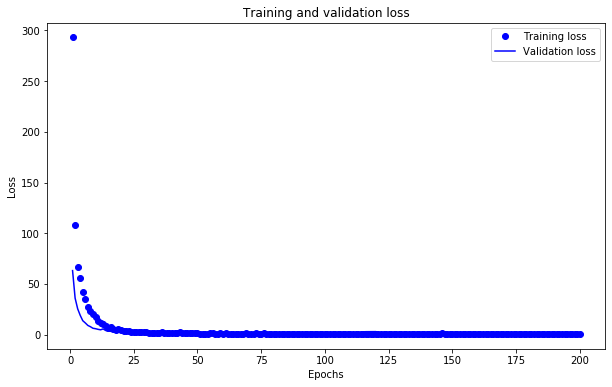

In [151]:
# plot the results of loss values from the training set and validtion set
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(history_dict['accuracy']) + 1)

plt.figure(figsize=(10,6))
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

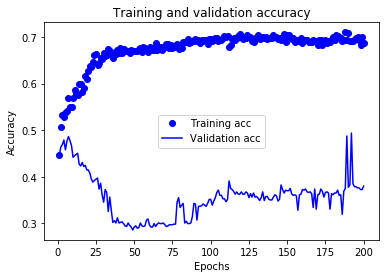

In [152]:
# plot the results of accuracy from the training set and validtion set
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()